In [1]:
from alibi.explainers import ALE, plot_ale
import alibi
from sklearn.inspection import permutation_importance
from pandas.core.arrays.sparse import dtype
import set_base_path
import time
import datetime

from imblearn.over_sampling import SMOTE
from sklearn.pipeline import Pipeline
from sklearn.model_selection import RandomizedSearchCV, train_test_split
#  Moldeling Libraries
from lazypredict.Supervised import LazyClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import ExtraTreesClassifier
# Scoring Libraries
from sklearn.metrics import classification_report, roc_auc_score, f1_score, accuracy_score, balanced_accuracy_score

from IPython.display import display
import xgboost as xgb

import src.utils.modeling as mu

import pandas as pd
import numpy as np
from enum import Enum, auto
import warnings


import seaborn as sns
import matplotlib.pyplot as plt
import plotly.graph_objects as go
import plotly.figure_factory as ff
import plotly.express as px

from src.constants import *

warnings.filterwarnings('ignore')
%matplotlib inline

# Pandas settings

In [2]:
pd.options.display.max_columns = None
pd.options.display.max_rows = 500
pd.options.display.width = None
pd.options.display.max_colwidth = 100
pd.options.display.precision = 3


### read data

In [3]:
merged_df = pd.read_feather(INTERIM_DATA_PATH/"merged_df.feather")
merged_df_scaled = pd.read_feather(INTERIM_DATA_PATH/"merged_df_scaled.feather")
merged_df_dimred = pd.read_feather(INTERIM_DATA_PATH/"merged_df_dimred.feather")


target_col_name = 'IS_SUSPECTED'

# Train test splitResidual Analysis

In [4]:
X_train_encoded, X_test_encoded, y_train_encoded, y_test_encoded = mu.split_data(merged_df_scaled.drop(target_col_name, axis=1), merged_df_scaled[[target_col_name]])
X_train_dim_red, X_test_dim_red, y_train_dim_red, y_test_dim_red = mu.split_data(merged_df_dimred, merged_df_dimred[[target_col_name]])


In [5]:
print(
    (y_train_encoded.sum()*100)/len(y_train_encoded),
    (y_test_encoded.sum()*100)/len(y_test_encoded),
    (y_train_dim_red.sum()*100)/len(y_train_dim_red),
    (y_test_dim_red.sum()*100)/len(y_test_dim_red),
)


IS_SUSPECTED   13.96
dtype: float64 IS_SUSPECTED   14.73
dtype: float64 IS_SUSPECTED   13.96
dtype: float64 IS_SUSPECTED   14.73
dtype: float64


# Class Balancing

In [6]:
sm = SMOTE(random_state=42)
X_res_enc, y_res_enc = sm.fit_resample(X_train_encoded, y_train_encoded)
X_res_dim_red, y_res_dim_red = sm.fit_resample(X_train_dim_red, y_train_dim_red)


In [7]:
print(
    (y_res_enc.sum()*100)/len(y_res_enc),
    (y_res_dim_red.sum()*100)/len(y_res_dim_red)
)



IS_SUSPECTED   50.00
dtype: float64 IS_SUSPECTED   50.00
dtype: float64


# Create model

In [8]:
# fit all models
clf_enc = LazyClassifier(predictions=True,  save_model=True, base_path=ENC_MODEL_PATH)
models_res_enc, predictions_enc = clf_enc.fit(X_res_enc, X_test_encoded, y_res_enc, y_test_encoded)
models_enc = clf_enc.provide_models(X_res_enc, X_test_encoded, y_res_enc, y_test_encoded)

100%|██████████| 30/30 [09:17<00:00, 18.59s/it]


In [9]:
clf_dim_red = LazyClassifier(predictions=True, save_model=True, base_path=DIMRED_MODEL_PATH)
models_res_dim_red, predictions_dim_red = clf_dim_red.fit(X_res_dim_red, X_test_dim_red, y_res_dim_red, y_test_dim_red)
models_dim_red = clf_dim_red.provide_models(X_res_dim_red, X_test_dim_red, y_res_dim_red, y_test_dim_red)


100%|██████████| 30/30 [08:29<00:00, 16.98s/it]


In [10]:
print(f"Models with encoded data")
display(models_res_enc)

Models with encoded data


,Accuracy,Balanced Accuracy,ROC AUC,F1 Score,Time Taken
Model,,,,,
AdaBoostClassifier,1.00,1.00,1.00,1.00,0.50
ExtraTreesClassifier,1.00,1.00,1.00,1.00,2.65
XGBClassifier,1.00,1.00,1.00,1.00,2.74
RidgeClassifierCV,1.00,1.00,1.00,1.00,1.34
RidgeClassifier,1.00,1.00,1.00,1.00,0.63
BaggingClassifier,1.00,1.00,1.00,1.00,1.15
LGBMClassifier,1.00,1.00,1.00,1.00,0.97
DecisionTreeClassifier,1.00,1.00,1.00,1.00,0.43
LinearSVC,1.00,1.00,1.00,1.00,1.13


In [11]:
print(f"Models with dimensionality reduced data")
display(models_res_dim_red)


Models with dimensionality reduced data


,Accuracy,Balanced Accuracy,ROC AUC,F1 Score,Time Taken
Model,,,,,
LinearSVC,1.00,1.00,1.00,1.00,0.98
LogisticRegression,1.00,1.00,1.00,1.00,0.61
CalibratedClassifierCV,1.00,1.00,1.00,1.00,3.39
PassiveAggressiveClassifier,1.00,1.00,1.00,1.00,0.41
SGDClassifier,0.99,0.99,0.99,0.99,0.46
LGBMClassifier,0.99,0.98,0.98,0.99,2.78
XGBClassifier,0.99,0.98,0.98,0.99,15.11
Perceptron,0.99,0.97,0.97,0.99,0.50
AdaBoostClassifier,0.98,0.97,0.97,0.98,36.70


In [12]:
linear = 'linear'
rf = 'rf'
model_obj = 'model'
params_dict = 'params'
models = {
    linear: {model_obj: LogisticRegression(random_state=42, n_jobs=-1), params_dict: dict(
        penalty=['l1', 'l2', 'elasticnet', 'none'],
        tol=[1e-4, 1e-3, 1e-2, 1e-1, 1e+0, 1e+1, 1e+2],
        C=[1e-3, 1e-2, 1e-1, 1e+0, 1e+1, 1e+2],
        solver=['newton-cg', 'lbfgs', 'liblinear', 'sag', 'saga']
    )},
    rf: {model_obj: ExtraTreesClassifier(random_state=42, n_jobs=-1), params_dict: dict(
        n_estimators=[10, 20, 50, 100, 200, 500, 1000],
        criterion=["gini", "entropy"],
        max_depth=[2, 3, 5, 10, 20, 50, 100, 200],
        min_samples_split=[2, 3, 5, 10, 20, 50, 100, 200, 500, 1000],
        min_samples_leaf=[2, 3, 5, 10, 20, 50, 100, 200, 500, 1000],
        max_features=["auto", "sqrt", "log2"],
        max_leaf_nodes=[10, 20, 50, 100, 200, 500, 1000]
    )}
}


In [13]:


show_graphs = True

trained_models = []

all_model_metrics = []
for model, model_config in models.items():
    print(f"Starting for {model.title()}")
    # With and without Dimensionality Reduction
    for mode in [mu.DataMode.ENCODED, mu.DataMode.ENCODED_DIM_RED]:
        X_train, X_test, y_train, y_test = (X_res_enc, X_test_encoded, y_res_enc, y_test_encoded) if mode == mu.DataMode.ENCODED else (
            X_res_dim_red, X_test_dim_red, y_res_dim_red, y_test_dim_red)
        data_mode_str = "without PCA" if mode == mu.DataMode.ENCODED else "with PCA"
        # Hyper- Parameter tuning
        ra_s_cv = RandomizedSearchCV(model_config.get(model_obj), model_config.get(params_dict), random_state=0, n_jobs=-1, cv=3, verbose=3, return_train_score=True)

        start_time = time.perf_counter()
        ra_s_cv.fit(X_train, y_train)
        end_time = time.perf_counter()

        train_pred = ra_s_cv.predict(X_train)
        test_pred = ra_s_cv.predict(X_test)

        print("-"*50)
        print(f"Best Estimator for {model} {data_mode_str} is {ra_s_cv.best_estimator_}\n")
        print(f"Best Params for {model} {data_mode_str} are {ra_s_cv.best_params_}\n")
        print(f"Cross validation Results for {model} {data_mode_str}\n")
        display(pd.DataFrame(ra_s_cv.cv_results_))
        print("-"*50)

        # Plot evaluation matrix
        mu.prepare_error_data_and_plot(ra_s_cv, X_train, y_train, train_pred, mode, model, show_graphs)
        mu.prepare_error_data_and_plot(ra_s_cv, X_test, y_test, test_pred, mode, model, show_graphs)
        # Collect Models
        model_string = f"{model.title()} {data_mode_str if mode == mu.DataMode.ENCODED_DIM_RED else ''}"
        trained_models.append((model_string, ra_s_cv.best_estimator_, mode))
        # Record performance
        all_model_metrics.append([model_string, ra_s_cv.best_score_, ra_s_cv.score(X_train, y_train),
                                  ra_s_cv.score(X_test, y_test.values),
                                  accuracy_score(y_train, train_pred),
                                  accuracy_score(y_test, test_pred),
                                  balanced_accuracy_score(y_train, train_pred),
                                  balanced_accuracy_score(y_test, test_pred),
                                  roc_auc_score(y_train, train_pred),
                                  roc_auc_score(y_test, test_pred),
                                  f1_score(y_train, train_pred),
                                  f1_score(y_test, test_pred),

                                  #   r2_score(y_train, train_pred), r2_score(y_test, test_pred), # Metrics on train and test
                                  end_time-start_time])
        print("="*50, "\n")

Starting for Linear
Fitting 3 folds for each of 10 candidates, totalling 30 fits
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  18 out of  30 | elapsed:    2.5s remaining:    1.7s
[Parallel(n_jobs=-1)]: Done  30 out of  30 | elapsed:    6.5s finished
--------------------------------------------------
Best Estimator for linear without PCA is LogisticRegression(C=10.0, n_jobs=-1, penalty='none', random_state=42,
                   solver='newton-cg', tol=0.1)

Best Params for linear without PCA are {'tol': 0.1, 'solver': 'newton-cg', 'penalty': 'none', 'C': 10.0}

Cross validation Results for linear without PCA



,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_tol,param_solver,param_penalty,param_C,params,split0_test_score,split1_test_score,split2_test_score,mean_test_score,std_test_score,rank_test_score,split0_train_score,split1_train_score,split2_train_score,mean_train_score,std_train_score
0,0.12,0.01,0.00,0.00,1.00,sag,elasticnet,0.10,"{'tol': 1.0, 'solver': 'sag', 'penalty': 'elasticnet', 'C': 0.1}",nan,nan,nan,nan,nan,5,nan,nan,nan,nan,nan
1,0.06,0.01,0.00,0.00,10.00,newton-cg,l1,0.01,"{'tol': 10.0, 'solver': 'newton-cg', 'penalty': 'l1', 'C': 0.01}",nan,nan,nan,nan,nan,6,nan,nan,nan,nan,nan
2,0.13,0.04,0.00,0.00,10.00,lbfgs,elasticnet,10.00,"{'tol': 10.0, 'solver': 'lbfgs', 'penalty': 'elasticnet', 'C': 10.0}",nan,nan,nan,nan,nan,7,nan,nan,nan,nan,nan
3,0.14,0.00,0.00,0.00,0.00,sag,elasticnet,0.01,"{'tol': 0.0001, 'solver': 'sag', 'penalty': 'elasticnet', 'C': 0.01}",nan,nan,nan,nan,nan,8,nan,nan,nan,nan,nan
4,3.22,0.33,0.02,0.00,0.10,newton-cg,none,10.00,"{'tol': 0.1, 'solver': 'newton-cg', 'penalty': 'none', 'C': 10.0}",1.00,1.00,1.00,1.00,0.00,1,1.00,1.00,1.00,1.00,0.00
5,1.55,0.02,0.03,0.00,0.00,lbfgs,none,10.00,"{'tol': 0.0001, 'solver': 'lbfgs', 'penalty': 'none', 'C': 10.0}",1.00,1.00,1.00,1.00,0.00,1,1.00,1.00,1.00,1.00,0.00
6,0.55,0.03,0.12,0.01,100.00,sag,none,0.01,"{'tol': 100.0, 'solver': 'sag', 'penalty': 'none', 'C': 0.01}",0.99,0.99,0.99,0.99,0.00,4,0.99,0.99,0.99,0.99,0.00
7,0.14,0.01,0.00,0.00,0.10,sag,l1,0.10,"{'tol': 0.1, 'solver': 'sag', 'penalty': 'l1', 'C': 0.1}",nan,nan,nan,nan,nan,9,nan,nan,nan,nan,nan
8,4.26,0.01,0.03,0.01,0.00,liblinear,l2,10.00,"{'tol': 0.0001, 'solver': 'liblinear', 'penalty': 'l2', 'C': 10.0}",1.00,1.00,1.00,1.00,0.00,1,1.00,1.00,1.00,1.00,0.00
9,0.18,0.02,0.00,0.00,0.10,saga,elasticnet,10.00,"{'tol': 0.1, 'solver': 'saga', 'penalty': 'elasticnet', 'C': 10.0}",nan,nan,nan,nan,nan,10,nan,nan,nan,nan,nan


--------------------------------------------------


array([[10091,     0],
       [    0, 10091]])

Classification Analysis graphs for "Train Data" linear without PCA


(array([0., 0., 1.]), array([0., 1., 1.]), array([2, 1, 0]))

array([[2500,    1],
       [   0,  432]])

Classification Analysis graphs for "Train Data" linear without PCA


(array([0.00000000e+00, 3.99840064e-04, 1.00000000e+00]),
 array([0., 1., 1.]),
 array([2, 1, 0]))


Fitting 3 folds for each of 10 candidates, totalling 30 fits
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  18 out of  30 | elapsed:    0.8s remaining:    0.6s
[Parallel(n_jobs=-1)]: Done  30 out of  30 | elapsed:    4.7s finished
--------------------------------------------------
Best Estimator for linear with PCA is LogisticRegression(C=10.0, n_jobs=-1, penalty='none', random_state=42,
                   solver='newton-cg', tol=0.1)

Best Params for linear with PCA are {'tol': 0.1, 'solver': 'newton-cg', 'penalty': 'none', 'C': 10.0}

Cross validation Results for linear with PCA



,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_tol,param_solver,param_penalty,param_C,params,split0_test_score,split1_test_score,split2_test_score,mean_test_score,std_test_score,rank_test_score,split0_train_score,split1_train_score,split2_train_score,mean_train_score,std_train_score
0,0.04,0.01,0.00,0.00,1.00,sag,elasticnet,0.10,"{'tol': 1.0, 'solver': 'sag', 'penalty': 'elasticnet', 'C': 0.1}",nan,nan,nan,nan,nan,5,nan,nan,nan,nan,nan
1,0.06,0.03,0.00,0.00,10.00,newton-cg,l1,0.01,"{'tol': 10.0, 'solver': 'newton-cg', 'penalty': 'l1', 'C': 0.01}",nan,nan,nan,nan,nan,6,nan,nan,nan,nan,nan
2,0.06,0.02,0.00,0.00,10.00,lbfgs,elasticnet,10.00,"{'tol': 10.0, 'solver': 'lbfgs', 'penalty': 'elasticnet', 'C': 10.0}",nan,nan,nan,nan,nan,7,nan,nan,nan,nan,nan
3,0.08,0.00,0.00,0.00,0.00,sag,elasticnet,0.01,"{'tol': 0.0001, 'solver': 'sag', 'penalty': 'elasticnet', 'C': 0.01}",nan,nan,nan,nan,nan,8,nan,nan,nan,nan,nan
4,2.18,0.05,0.02,0.00,0.10,newton-cg,none,10.00,"{'tol': 0.1, 'solver': 'newton-cg', 'penalty': 'none', 'C': 10.0}",1.00,1.00,1.00,1.00,0.00,1,1.00,1.00,1.00,1.00,0.00
5,1.16,0.07,0.03,0.00,0.00,lbfgs,none,10.00,"{'tol': 0.0001, 'solver': 'lbfgs', 'penalty': 'none', 'C': 10.0}",1.00,1.00,1.00,1.00,0.00,3,1.00,1.00,1.00,1.00,0.00
6,0.44,0.02,0.05,0.02,100.00,sag,none,0.01,"{'tol': 100.0, 'solver': 'sag', 'penalty': 'none', 'C': 0.01}",0.99,0.99,0.98,0.99,0.00,4,0.99,0.99,0.99,0.99,0.00
7,0.18,0.01,0.00,0.00,0.10,sag,l1,0.10,"{'tol': 0.1, 'solver': 'sag', 'penalty': 'l1', 'C': 0.1}",nan,nan,nan,nan,nan,9,nan,nan,nan,nan,nan
8,3.96,0.17,0.01,0.00,0.00,liblinear,l2,10.00,"{'tol': 0.0001, 'solver': 'liblinear', 'penalty': 'l2', 'C': 10.0}",1.00,1.00,1.00,1.00,0.00,1,1.00,1.00,1.00,1.00,0.00
9,0.09,0.01,0.00,0.00,0.10,saga,elasticnet,10.00,"{'tol': 0.1, 'solver': 'saga', 'penalty': 'elasticnet', 'C': 10.0}",nan,nan,nan,nan,nan,10,nan,nan,nan,nan,nan


--------------------------------------------------


array([[10091,     0],
       [    0, 10091]])

Classification Analysis graphs for "Train Data" linear with PCA


(array([0., 0., 1.]), array([0., 1., 1.]), array([2, 1, 0]))

array([[2500,    1],
       [   0,  432]])

Classification Analysis graphs for "Train Data" linear with PCA


(array([0.00000000e+00, 3.99840064e-04, 1.00000000e+00]),
 array([0., 1., 1.]),
 array([2, 1, 0]))


Starting for Rf
Fitting 3 folds for each of 10 candidates, totalling 30 fits
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  18 out of  30 | elapsed:    4.4s remaining:    2.9s
[Parallel(n_jobs=-1)]: Done  30 out of  30 | elapsed:    6.4s finished
--------------------------------------------------
Best Estimator for rf without PCA is ExtraTreesClassifier(max_depth=100, max_features='sqrt', max_leaf_nodes=200,
                     min_samples_leaf=2, min_samples_split=50, n_estimators=200,
                     n_jobs=-1, random_state=42)

Best Params for rf without PCA are {'n_estimators': 200, 'min_samples_split': 50, 'min_samples_leaf': 2, 'max_leaf_nodes': 200, 'max_features': 'sqrt', 'max_depth': 100, 'criterion': 'gini'}

Cross validation Results for rf without PCA



,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_n_estimators,param_min_samples_split,param_min_samples_leaf,param_max_leaf_nodes,param_max_features,param_max_depth,param_criterion,params,split0_test_score,split1_test_score,split2_test_score,mean_test_score,std_test_score,rank_test_score,split0_train_score,split1_train_score,split2_train_score,mean_train_score,std_train_score
0,0.45,0.04,0.09,0.03,20,200,200,200,sqrt,50,entropy,"{'n_estimators': 20, 'min_samples_split': 200, 'min_samples_leaf': 200, 'max_leaf_nodes': 200, '...",0.94,0.97,1.00,0.97,0.02,3,0.96,0.96,1.00,0.97,0.02
1,5.74,0.02,0.24,0.00,1000,10,5,1000,log2,5,gini,"{'n_estimators': 1000, 'min_samples_split': 10, 'min_samples_leaf': 5, 'max_leaf_nodes': 1000, '...",0.96,0.98,0.96,0.97,0.01,5,0.97,0.97,0.96,0.97,0.00
2,0.41,0.02,0.07,0.01,20,5,3,100,log2,10,entropy,"{'n_estimators': 20, 'min_samples_split': 5, 'min_samples_leaf': 3, 'max_leaf_nodes': 100, 'max_...",0.97,0.92,0.96,0.95,0.02,9,0.98,0.91,0.95,0.95,0.03
3,0.51,0.10,0.11,0.03,50,2,50,10,auto,2,entropy,"{'n_estimators': 50, 'min_samples_split': 2, 'min_samples_leaf': 50, 'max_leaf_nodes': 10, 'max_...",0.95,0.98,0.95,0.96,0.01,8,0.96,0.98,0.94,0.96,0.02
4,0.93,0.04,0.29,0.08,100,2,500,10,auto,20,entropy,"{'n_estimators': 100, 'min_samples_split': 2, 'min_samples_leaf': 500, 'max_leaf_nodes': 10, 'ma...",0.96,0.98,0.96,0.97,0.01,4,0.97,0.98,0.95,0.97,0.01
5,0.56,0.03,0.27,0.04,50,1000,50,10,sqrt,5,entropy,"{'n_estimators': 50, 'min_samples_split': 1000, 'min_samples_leaf': 50, 'max_leaf_nodes': 10, 'm...",0.94,0.97,0.99,0.97,0.02,6,0.96,0.97,0.98,0.97,0.01
6,4.16,0.04,0.28,0.04,200,50,2,200,sqrt,100,gini,"{'n_estimators': 200, 'min_samples_split': 50, 'min_samples_leaf': 2, 'max_leaf_nodes': 200, 'ma...",1.00,1.00,1.00,1.00,0.00,1,1.00,1.00,1.00,1.00,0.00
7,2.84,0.11,0.47,0.12,100,500,20,1000,sqrt,100,gini,"{'n_estimators': 100, 'min_samples_split': 500, 'min_samples_leaf': 20, 'max_leaf_nodes': 1000, ...",1.00,1.00,1.00,1.00,0.00,1,1.00,1.00,1.00,1.00,0.00
8,0.65,0.15,0.50,0.04,10,1000,1000,100,log2,5,gini,"{'n_estimators': 10, 'min_samples_split': 1000, 'min_samples_leaf': 1000, 'max_leaf_nodes': 100,...",0.72,0.76,0.75,0.74,0.01,10,0.75,0.74,0.74,0.74,0.01
9,1.10,0.25,0.17,0.04,50,3,3,10,sqrt,2,entropy,"{'n_estimators': 50, 'min_samples_split': 3, 'min_samples_leaf': 3, 'max_leaf_nodes': 10, 'max_f...",0.95,0.98,0.95,0.96,0.01,7,0.96,0.98,0.94,0.96,0.02


--------------------------------------------------


array([[10091,     0],
       [    0, 10091]])

Classification Analysis graphs for "Train Data" rf without PCA


(array([0., 0., 1.]), array([0., 1., 1.]), array([2, 1, 0]))

array([[2501,    0],
       [   0,  432]])

Classification Analysis graphs for "Train Data" rf without PCA


(array([0., 0., 1.]), array([0., 1., 1.]), array([2, 1, 0]))


Fitting 3 folds for each of 10 candidates, totalling 30 fits
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  18 out of  30 | elapsed:    4.4s remaining:    3.0s
[Parallel(n_jobs=-1)]: Done  30 out of  30 | elapsed:    6.5s finished
--------------------------------------------------
Best Estimator for rf with PCA is ExtraTreesClassifier(max_depth=100, max_features='sqrt', max_leaf_nodes=200,
                     min_samples_leaf=2, min_samples_split=50, n_estimators=200,
                     n_jobs=-1, random_state=42)

Best Params for rf with PCA are {'n_estimators': 200, 'min_samples_split': 50, 'min_samples_leaf': 2, 'max_leaf_nodes': 200, 'max_features': 'sqrt', 'max_depth': 100, 'criterion': 'gini'}

Cross validation Results for rf with PCA



,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_n_estimators,param_min_samples_split,param_min_samples_leaf,param_max_leaf_nodes,param_max_features,param_max_depth,param_criterion,params,split0_test_score,split1_test_score,split2_test_score,mean_test_score,std_test_score,rank_test_score,split0_train_score,split1_train_score,split2_train_score,mean_train_score,std_train_score
0,0.50,0.07,0.05,0.01,20,200,200,200,sqrt,50,entropy,"{'n_estimators': 20, 'min_samples_split': 200, 'min_samples_leaf': 200, 'max_leaf_nodes': 200, '...",0.99,0.99,0.99,0.99,0.00,8,0.99,0.99,0.98,0.99,0.01
1,5.87,0.02,0.25,0.00,1000,10,5,1000,log2,5,gini,"{'n_estimators': 1000, 'min_samples_split': 10, 'min_samples_leaf': 5, 'max_leaf_nodes': 1000, '...",0.99,1.00,1.00,0.99,0.00,7,1.00,1.00,1.00,1.00,0.00
2,0.45,0.02,0.11,0.02,20,5,3,100,log2,10,entropy,"{'n_estimators': 20, 'min_samples_split': 5, 'min_samples_leaf': 3, 'max_leaf_nodes': 100, 'max_...",0.94,0.96,0.96,0.96,0.01,9,0.97,0.96,0.96,0.96,0.00
3,0.63,0.03,0.11,0.05,50,2,50,10,auto,2,entropy,"{'n_estimators': 50, 'min_samples_split': 2, 'min_samples_leaf': 50, 'max_leaf_nodes': 10, 'max_...",1.00,1.00,1.00,1.00,0.00,5,1.00,1.00,1.00,1.00,0.00
4,0.99,0.06,0.24,0.12,100,2,500,10,auto,20,entropy,"{'n_estimators': 100, 'min_samples_split': 2, 'min_samples_leaf': 500, 'max_leaf_nodes': 10, 'ma...",1.00,1.00,1.00,1.00,0.00,6,1.00,1.00,1.00,1.00,0.00
5,0.61,0.04,0.17,0.11,50,1000,50,10,sqrt,5,entropy,"{'n_estimators': 50, 'min_samples_split': 1000, 'min_samples_leaf': 50, 'max_leaf_nodes': 10, 'm...",1.00,1.00,1.00,1.00,0.00,3,1.00,1.00,1.00,1.00,0.00
6,3.96,0.04,0.29,0.08,200,50,2,200,sqrt,100,gini,"{'n_estimators': 200, 'min_samples_split': 50, 'min_samples_leaf': 2, 'max_leaf_nodes': 200, 'ma...",1.00,1.00,1.00,1.00,0.00,1,1.00,1.00,1.00,1.00,0.00
7,2.07,0.18,0.52,0.15,100,500,20,1000,sqrt,100,gini,"{'n_estimators': 100, 'min_samples_split': 500, 'min_samples_leaf': 20, 'max_leaf_nodes': 1000, ...",1.00,1.00,1.00,1.00,0.00,2,1.00,1.00,1.00,1.00,0.00
8,0.87,0.13,0.35,0.16,10,1000,1000,100,log2,5,gini,"{'n_estimators': 10, 'min_samples_split': 1000, 'min_samples_leaf': 1000, 'max_leaf_nodes': 100,...",0.77,0.75,0.75,0.76,0.01,10,0.78,0.73,0.74,0.75,0.02
9,0.77,0.10,0.16,0.11,50,3,3,10,sqrt,2,entropy,"{'n_estimators': 50, 'min_samples_split': 3, 'min_samples_leaf': 3, 'max_leaf_nodes': 10, 'max_f...",1.00,1.00,1.00,1.00,0.00,4,1.00,1.00,1.00,1.00,0.00


--------------------------------------------------


array([[10091,     0],
       [    0, 10091]])

Classification Analysis graphs for "Train Data" rf with PCA


(array([0., 0., 1.]), array([0., 1., 1.]), array([2, 1, 0]))

array([[2501,    0],
       [   1,  431]])

Classification Analysis graphs for "Train Data" rf with PCA


(array([0., 0., 1.]),
 array([0.        , 0.99768519, 1.        ]),
 array([2, 1, 0]))

In [14]:

perf_frame = pd.DataFrame(all_model_metrics, columns=["Algo", "Best Training Score (CV)", "Train Score", "Test Score",
                                                      "Train Accuracy", "Test Accuracy",
                                                      "Balanced Train Accuracy", "Balanced Test Accuracy",
                                                      "Train ROC AUC", "Test ROC AUC",
                                                      "Train F1 Score", "Test F1 Score",
                                                      "Time Taken(Sec)"])

perf_frame.sort_values(by=["Test F1 Score", "Train F1 Score", "Balanced Test Accuracy", "Test Accuracy", "Time Taken(Sec)"], ascending=[False, False, False, False, True]).style.hide_index()



Algo,Best Training Score (CV),Train Score,Test Score,Train Accuracy,Test Accuracy,Balanced Train Accuracy,Balanced Test Accuracy,Train ROC AUC,Test ROC AUC,Train F1 Score,Test F1 Score,Time Taken(Sec)
Rf,1.000,1.000,1.000,1.000,1.000,1.000,1.000,1.000,1.000,1.000,1.000,7.904
Linear with PCA,1.000,1.000,1.000,1.000,1.000,1.000,1.000,1.000,1.000,1.000,0.999,5.597
Linear,1.000,1.000,1.000,1.000,1.000,1.000,1.000,1.000,1.000,1.000,0.999,8.009
Rf with PCA,1.000,1.000,1.000,1.000,1.000,1.000,0.999,1.000,0.999,1.000,0.999,7.787


In [16]:
trained_models

[('Linear ',
  LogisticRegression(C=10.0, n_jobs=-1, penalty='none', random_state=42,
                     solver='newton-cg', tol=0.1),
  <DataMode.ENCODED: 1>),
 ('Linear with PCA',
  LogisticRegression(C=10.0, n_jobs=-1, penalty='none', random_state=42,
                     solver='newton-cg', tol=0.1),
  <DataMode.ENCODED_DIM_RED: 2>),
 ('Rf ',
  ExtraTreesClassifier(max_depth=100, max_features='sqrt', max_leaf_nodes=200,
                       min_samples_leaf=2, min_samples_split=50, n_estimators=200,
                       n_jobs=-1, random_state=42),
  <DataMode.ENCODED: 1>),
 ('Rf with PCA',
  ExtraTreesClassifier(max_depth=100, max_features='sqrt', max_leaf_nodes=200,
                       min_samples_leaf=2, min_samples_split=50, n_estimators=200,
                       n_jobs=-1, random_state=42),
  <DataMode.ENCODED_DIM_RED: 2>)]

In [17]:
best_model_for_feature_importance = trained_models[2][1]

In [18]:
best_model_for_feature_importance.feature_importances_

array([1.31217080e-03, 3.07247781e-04, 5.82948485e-04, 1.12102248e-03,
       6.60587710e-04, 1.72920235e-04, 4.91206080e-05, 1.08025951e-05,
       2.18304752e-05, 0.00000000e+00, 6.51771502e-04, 3.01028496e-04,
       1.63446642e-05, 1.35206620e-05, 1.96412356e-05, 5.77875116e-04,
       2.03701677e-05, 6.54747048e-06, 8.68394282e-06, 3.98074248e-06,
       2.42073954e-03, 2.14896291e-05, 0.00000000e+00, 1.13931696e-06,
       3.20754612e-06, 3.66815282e-06, 1.14279883e-05, 0.00000000e+00,
       3.47325999e-05, 0.00000000e+00, 1.95446851e-05, 0.00000000e+00,
       5.20550541e-06, 1.41589740e-06, 3.41311856e-06, 1.62783018e-06,
       4.38450509e-06, 1.14959050e-05, 6.02119546e-06, 3.46822677e-06,
       2.31733469e-06, 1.20332810e-06, 2.95257471e-05, 6.38139492e-06,
       6.30089679e-06, 3.70463464e-07, 1.85846976e-06, 4.36881313e-06,
       1.03984014e-06, 5.59814908e-06, 2.02790962e-05, 0.00000000e+00,
       1.97727097e-05, 5.79848551e-06, 1.23759870e-05, 9.16911529e-06,
      

In [24]:
best_model =trained_models[2][1]
fe = pd.DataFrame({"Column": X_res_enc.columns,"Importance":best_model.feature_importances_})
fe.sort_values(by="Importance", key=abs, ascending=False).head(20).style.hide_index()


Column,Importance
FEC52EL3SUHJ(FEC52E)-MFTA_662,0.344
FEC52EL3SUHJ(FEC52E)-MFTA_631,0.083
FEC52E CANTER_611,0.066
STD_LDT_CA_EMISSION_60M_100000MILE_200001_263,0.044
OTHER_CAUSAL_REG_PARTS_363,0.017
FEC72C CANTER_614,0.017
DAYS_SINCE_FAILURE_250,0.016
FEC72HL3SUHD(FEC72H)-MFTA_670,0.015
"AIR CLEANER, TURBOCHARGER-ORIFICE, CRANKCASE VENTILATION_414",0.014
FEC72HL3SUHD(FEC72H)-MFTA_639,0.013


In [26]:
shap.initjs()

In [27]:
explainer = shap.TreeExplainer(best_model, data=X_res_enc)
shap_res = explainer.shap_values(X_res_enc, y_res_enc)

100%|===================| 40327/40364 [09:54<00:00]       

In [35]:
i = 0
shap.force_plot(explainer.expected_value[i], shap_res[i][0], features=X_res_enc.loc[i],
                feature_names=X_res_enc.columns)

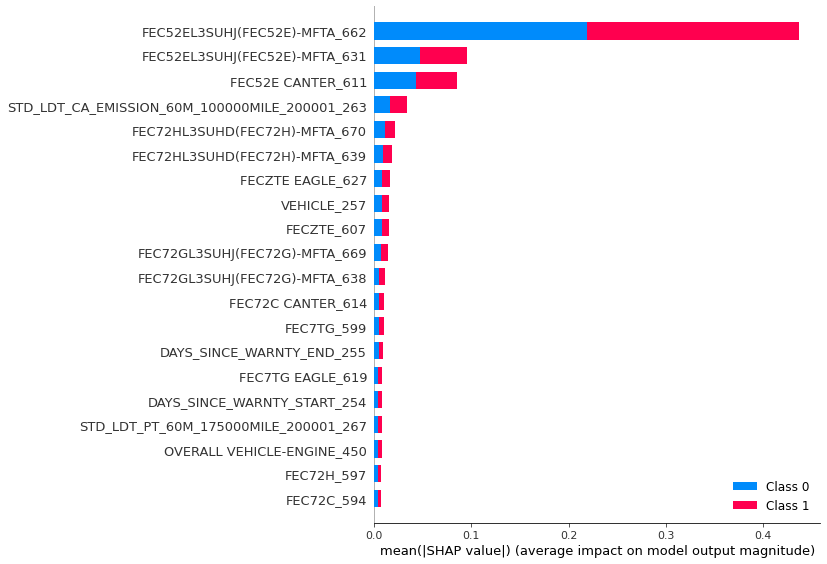

In [36]:
shap.summary_plot(shap_res, X_res_enc, X_res_enc.columns)
# features: Our training set of independent variables
# feature_names: list of column names from the above training set